In [2]:
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split as sample
from sklearn.manifold import MDS
# делаем импорт всех необходимых библиотек
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid", palette="muted")
# Отключение некоторых лишних предупреждений
import warnings
warnings.filterwarnings("ignore")

## Часть 3: Гипотезы

### 1. Отбираем группу респондентов:

Чтобы строить некоторые гипотезы, мы будем смотреть только на "болеющих" респондентов(судя по целевым признакам), поэтому выделим их в отдельную группу.

In [3]:
data_heart = pd.read_csv("data_heart.csv", index_col=['Unnamed: 0'])

In [4]:
data_stroke = pd.read_csv("data_stroke.csv", index_col=['Unnamed: 0'])

In [ ]:
sick_stroke = data_stroke[data_stroke['stroke'] == 1]
sick_heart = data_heart[data_heart['HeartDiseaseorAttack'] == 1]   

### 2. Посмотрим на доли различных призаков в полученных группах:

#### 1) Здоровый образ жизни:

Text(0.5, 1.0, 'Доля респондентов с заболеваниями сердца, ведущие здоровый образ жизни')

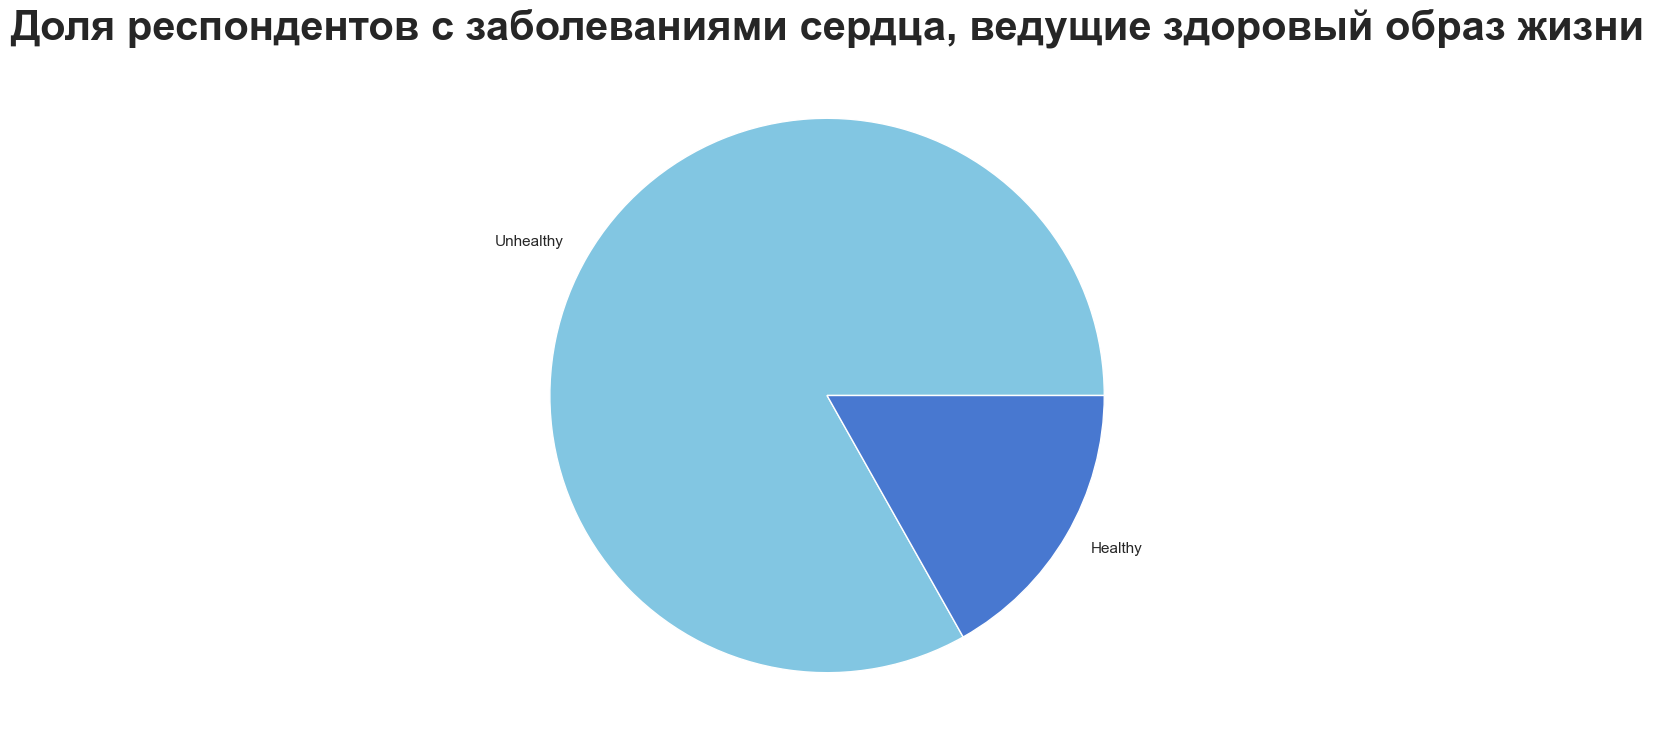

In [ ]:
plt.figure(figsize=[30, 9])

plt.pie(sick_heart['healthy_lifestyle'].value_counts().values, 
        colors=['c', 'b'], 
        labels=['Unhealthy', 'Healthy'])
plt.title('Доля респондентов с заболеваниями сердца, ведущие здоровый образ жизни', fontsize=30, fontweight='bold')

#### 2) Избыточный индекс массы тела:

Text(0.5, 1.0, 'Инсульт')

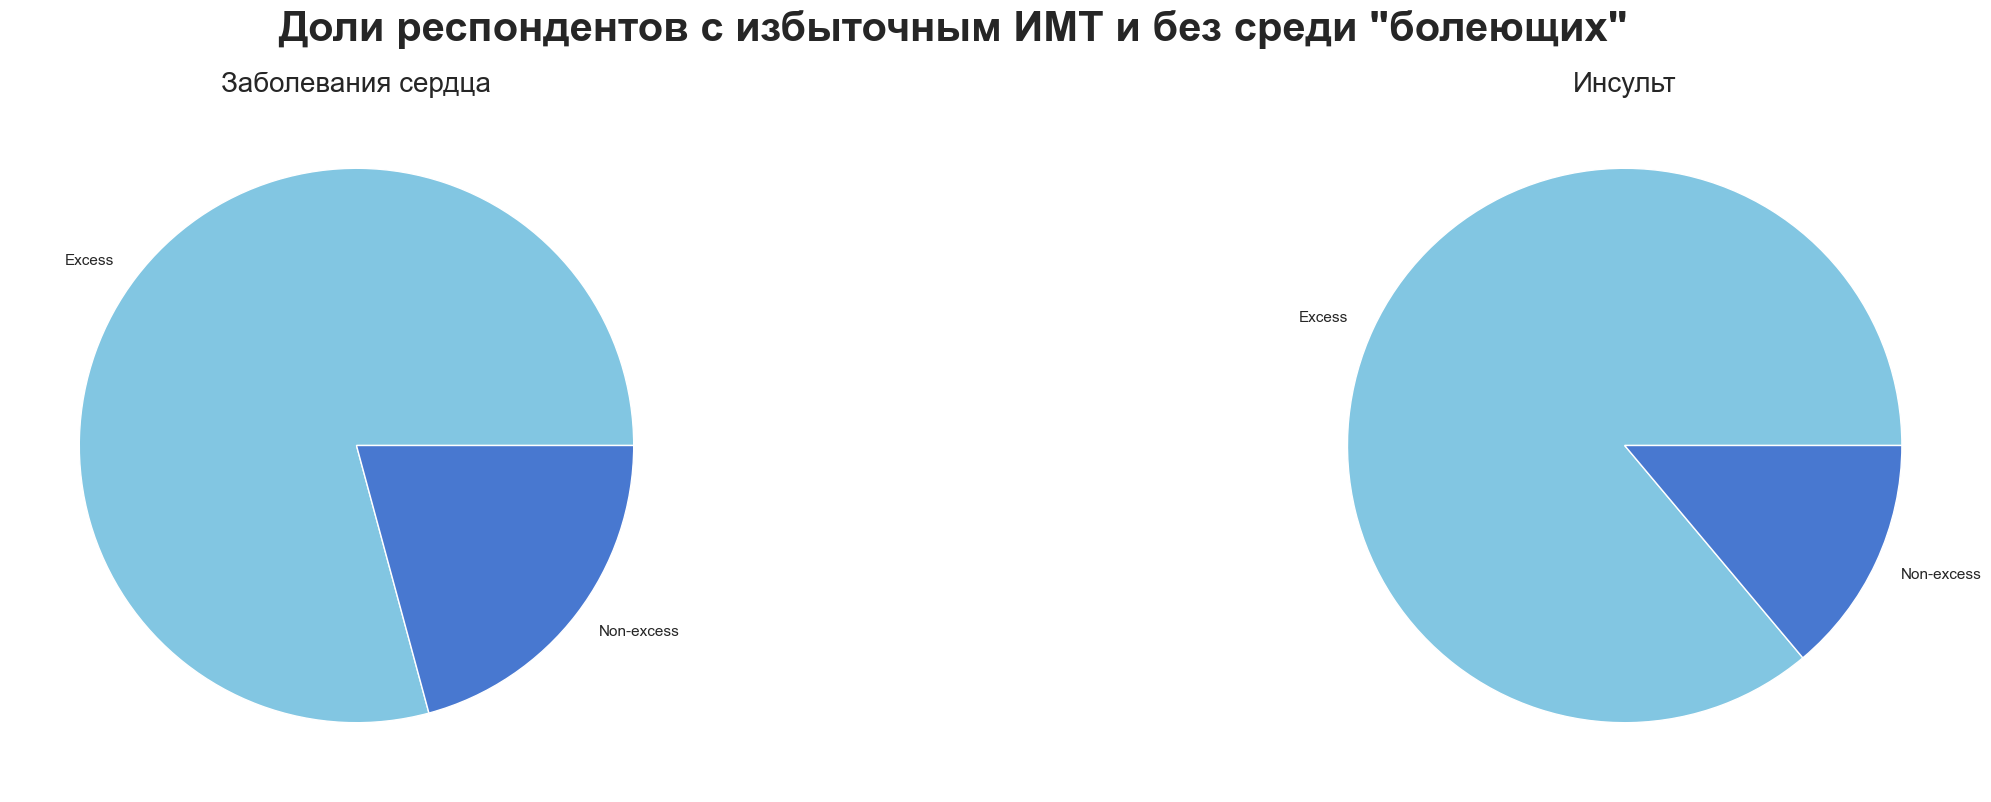

In [ ]:
plt.figure(figsize=[30, 9])
plt.suptitle('Доли респондентов с избыточным ИМТ и без среди "болеющих"', fontsize=30, fontweight='bold')

plt.subplot(1, 2, 1)
plt.pie(sick_heart['BMI_excess'].value_counts().values, colors=['c', 'b'], labels=['Excess', 'Non-excess'])
plt.title('Заболевания сердца', fontsize=20)

plt.subplot(1, 2, 2)
plt.pie(sick_stroke['BMI_excess'].value_counts().values, colors=['c', 'b'], labels=['Excess', 'Non-excess'])
plt.title('Инсульт', fontsize=20)

#### 3) Некурящие респонденты:

Text(0.5, 1.0, 'Инсульт')

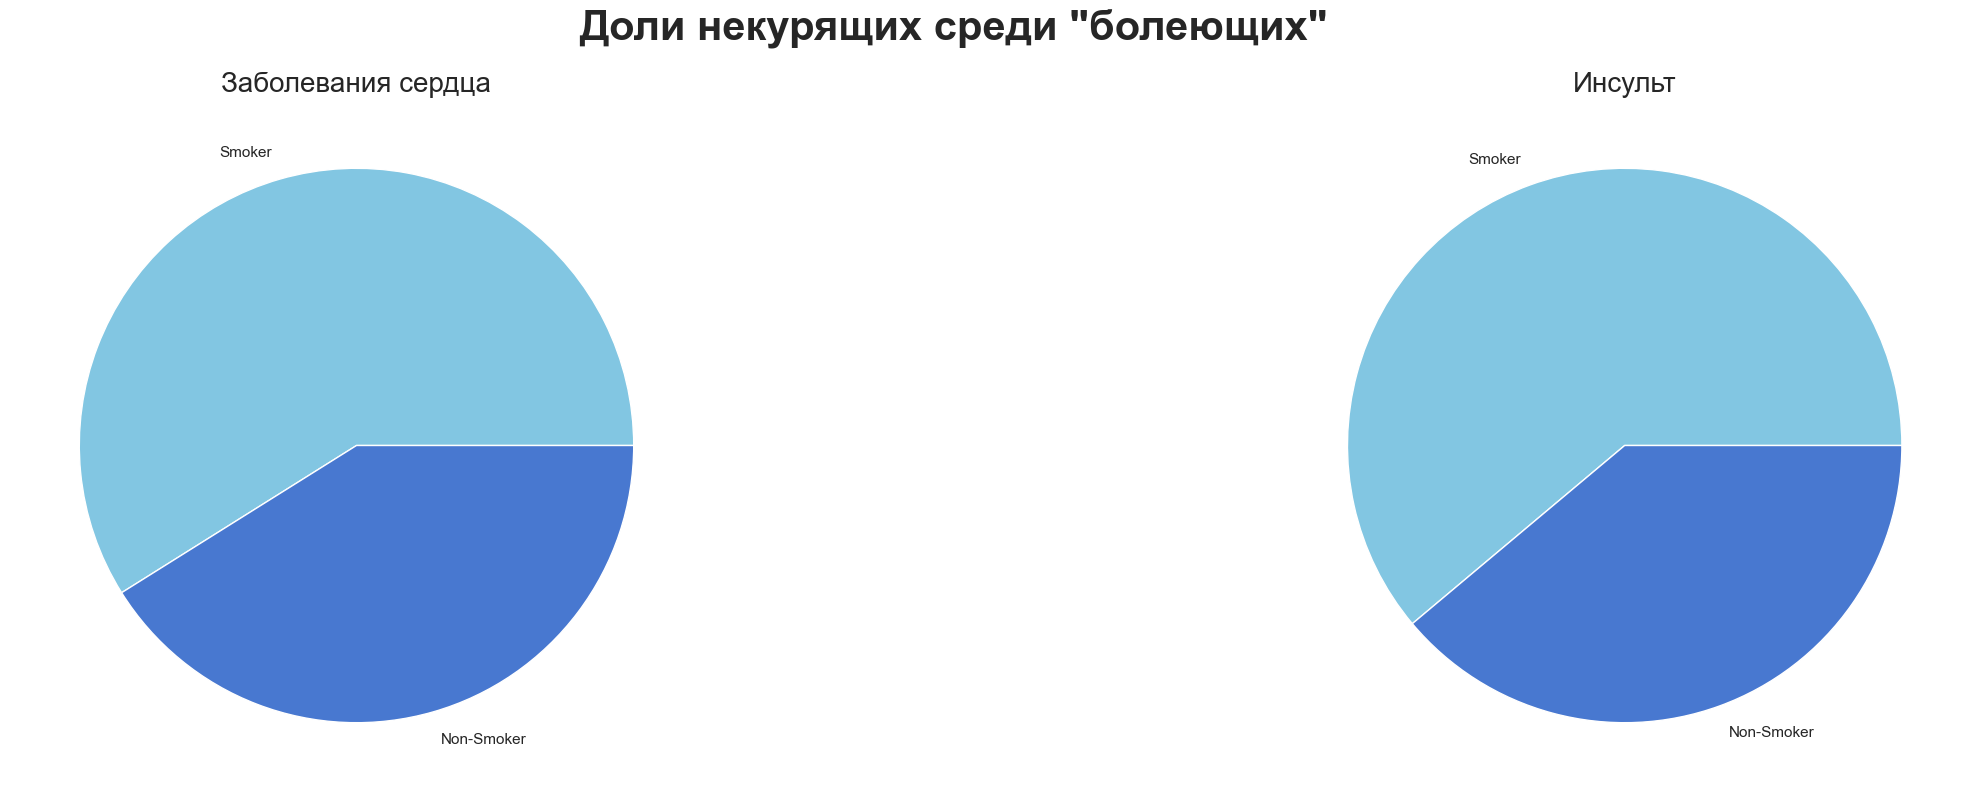

In [ ]:
plt.figure(figsize=[30, 9])
plt.suptitle('Доли некурящих среди "болеющих"', fontsize=30, fontweight='bold')

plt.subplot(1, 2, 1)
plt.pie(sick_heart['Smoker'].value_counts().values, colors=['c', 'b'], labels=['Smoker', 'Non-Smoker'])
plt.title('Заболевания сердца', fontsize=20)

plt.subplot(1, 2, 2)
plt.pie(sick_stroke['smoking_status_never smoked'].value_counts().values, 
        colors=['c', 'b'], 
        labels=['Smoker', 'Non-Smoker'])
plt.title('Инсульт', fontsize=20)

#### 4) Уровень глюкозы:

Text(0.5, 1.0, 'Доля респондентов с нормальным уровнем глюкозы в крови среди "болеющих"')

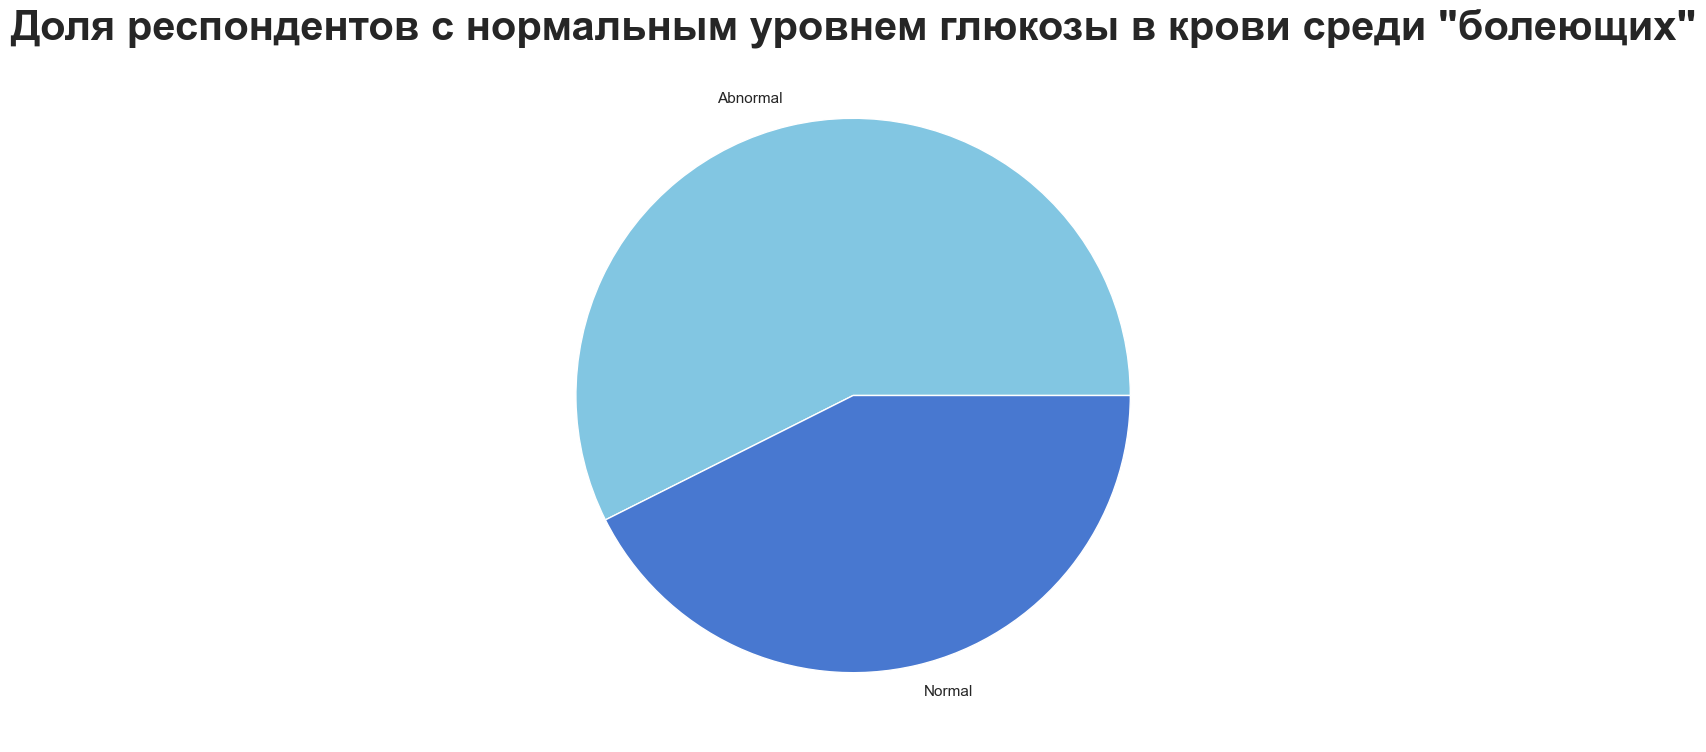

In [ ]:
plt.figure(figsize=[30, 9])

plt.pie(sick_stroke['glucose_level_normal'].value_counts().values, 
        colors=['c', 'b'], 
        labels=['Abnormal', 'Normal'])
plt.title('Доля респондентов с нормальным уровнем глюкозы в крови среди "болеющих"', fontsize=30, fontweight='bold')

### 3. Выдвинем гипотезы и проверим их:

__Замечание:__
- Выше мы построили несколько графиков и, изучив закономерности, мы выдвинули гипотезы на основе некоторых из них.
- Все гипотезы проверяются на 5% уровне значимости.
- Для проверки и визуализации гипотез о долях, мы используем уже готовую функцию с семинара.

In [ ]:
# сохраним функцию с семинара
def asy_mean_test(mean_hat, std_hat, mu_0=0, 
                   alpha=0.05, alternative='two-sided', margin=3):
    """
        Асимптотический тест для равенства средних
    """
    
    z_obs = abs((mean_hat - mu_0)/std_hat)
    
    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
        z_crit = stats.norm().ppf(1 - alpha/2)
        
        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (z_crit, 0.05, z_crit, margin, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r'), 
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    if alternative == 'less':
        p_value = stats.norm().cdf(-z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    
    plt.figure(figsize = (8, 4))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]
    
    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin, 
                 h*y_max, round(statistic, 2), color=color, fontsize=16)
        
        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)
    
    return p_value

__Гипотеза 1:__

Если посмотреть на график в пункте (1), можно заметить, что доля респондентов с заболеваниями сердца, ведущих нездоровый образ жихни, составляет около 80%.

Это можно сформулировать в виде следующих гипотез:
$$
\begin{aligned}
&H_0: \hspace{2mm} p = 0.8 \\
&H_1: \hspace{2mm} p \neq 0.8 
\end{aligned}
$$

Для этого используем асимптотический z-критерий для доли.

0.26026878270752984

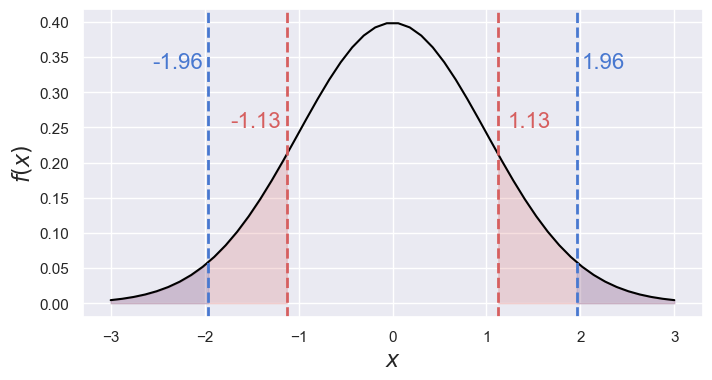

In [ ]:
n = sick_heart.shape[0] #длина выборки
p_0 = 0.8 #оценка доли
p_hat = 1 - sick_heart['healthy_lifestyle'].mean() #значение доли на выборке
std_hat = np.sqrt(p_0  * (1 - p_0) / n) #стандартное отклонение

asy_mean_test(p_hat, std_hat, mu_0=p_0)

__Вывод:__ Значение наблюдаемой статистики попадает в интервал между критическими значениями, значит на уровне значимости 5% нулевая гипотеза НЕ отвергается.

__Гипотеза 2:__

Если посмотреть на график в пункте (4), можно заметить, что доля респондентов с инсультом, у которых уровень глюкозы в крови находится в норме, составляет немного меньше 50%.

Это можно сформулировать в виде следующих гипотез:
$$
\begin{aligned}
&H_0: \hspace{2mm} p = 0.5 \\
&H_1: \hspace{2mm} p < 0.5 
\end{aligned}
$$

Для этого используем асимптотический z-критерий для доли.

0.06182885520141674

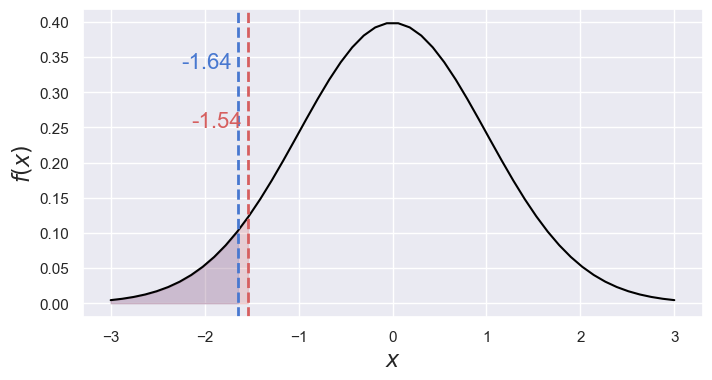

In [ ]:
n = sick_stroke.shape[0] #длина выборки
p_0 = 0.5 #оценка доли
p_hat = sick_stroke['glucose_level_normal'].mean() #значение доли на выборке
std_hat = np.sqrt(p_0  * (1 - p_0) / n) #стандартное отклонение

asy_mean_test(p_hat, std_hat, mu_0=p_0, alternative='less')

__Вывод:__ Значение наблюдаемой статистики не попало в хвост, значит на уровне значимости 5% нулевая гипотеза НЕ отвергается.

__Гипотеза 3:__

Судя по круговой диаграмме из пункта (2), доля респондентов с избыточным ИМТ больше у тех, кто сталкивался с инсультом, а не с заболеваниями сердца.

Эти предположения можно сформулировать в виде следующих гипотез:
$$
\begin{aligned}
&H_0: \hspace{2mm} p_1 = p_2 \\
&H_1: \hspace{2mm} p_1 > p_2
\end{aligned}
$$

Для этого используем асимптотический z-критерий для разности долей.

0.05770590300344369

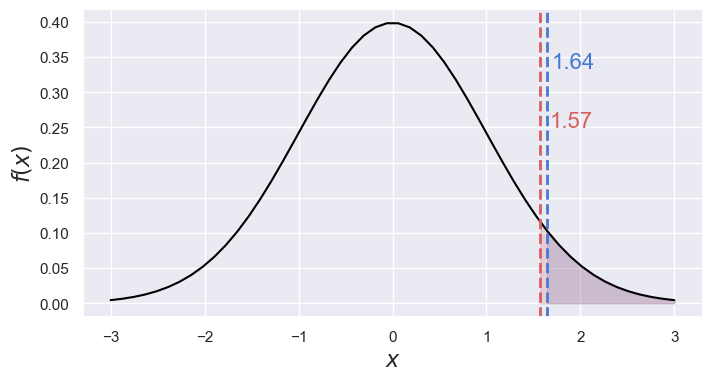

In [ ]:
#длины выборок
n2 = sick_heart.shape[0] 
n1 = sick_stroke.shape[0] 

#значения доле на выборках
p_2 = sick_heart['BMI_excess'].mean() 
p_1 = sick_stroke['BMI_excess'].mean()

#дисперсии
var_1 = p_1 * (1 - p_1) / n1
var_2 = p_2 * (1 - p_2) / n2

diff_p = p_1 - p_2 #разница долей
diff_std = np.sqrt(var_1 + var_2) #стандартное отклонение

asy_mean_test(diff_p, diff_std, alternative='larger')

__Вывод:__ Значение наблюдаемой статистики попадает в хвост, значит на уровне значимости 5% нулевая гипотеза НЕ отвергается.

__Гипотеза 4:__

Судя по круговой диаграмме из пункта (3), доли некурящих респондентов среди тех, кто сталкивался с заболеваниями сердца и инсультом, равны.

Эти предположения можно сформулировать в виде следующих гипотез:
$$
\begin{aligned}
&H_0: \hspace{2mm} p_1 = p_2 \\
&H_1: \hspace{2mm} p_1 \neq p_2
\end{aligned}
$$

Для этого используем асимптотический z-критерий для разности долей.

0.7058761909590343

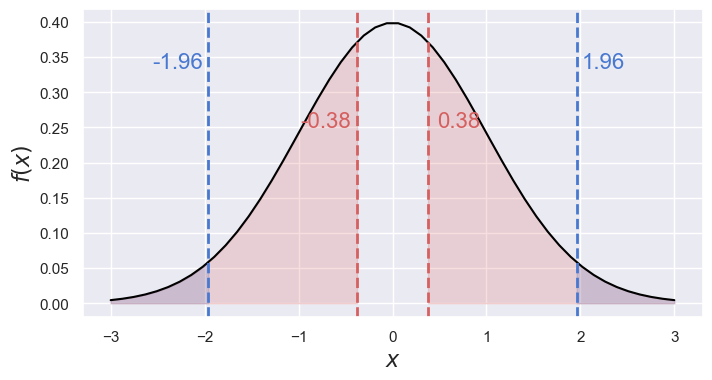

In [ ]:
#длины выборок
n1 = sick_heart.shape[0] 
n2 = sick_stroke.shape[0] 

#значения доле на выборках
p_1 = 1 - sick_heart['Smoker'].mean() 
p_2 = sick_stroke['smoking_status_never smoked'].mean()

#дисперсии
var_1 = p_1 * (1 - p_1) / n1
var_2 = p_2 * (1 - p_2) / n2

diff_p = p_1 - p_2 #разница долей
diff_std = np.sqrt(var_1 + var_2) #стандартное отклонение

asy_mean_test(diff_p, diff_std)

__Вывод:__ Наблюдаемая статистика попадает в интервал между критическими значениями, значит на уровне значимости 5% нулевая гипотеза НЕ отвергается.

__Гипотеза 5:__

Посмотрим снова на распределение индекса массы тела, построим его на одной плоскости с функцией плотности нориального распределения.

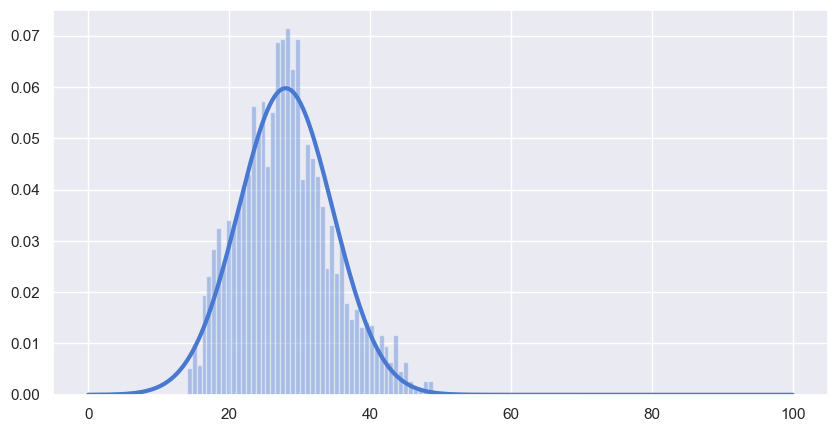

In [ ]:
info = data_stroke['bmi']
plt.figure(figsize=(10,5))
plt.hist(info, density=True, bins=50, alpha=0.4, color='b')

xs = np.linspace(0, 100, 300)
ys = stats.norm(loc=info.mean(), scale=info.std(ddof=1)).pdf(xs)
plt.plot(xs, ys, color='b', lw=3)

В целом распределения похожи, проверим следующую гипотезу с помощью теста Колмогорова:

\begin{equation*}
    \begin{aligned}
    & H_0: F_X(x) = N(\mu,\sigma^2)\\
    & H_A: F_X(x) \neq N(\mu,\sigma^2)\\
    \end{aligned}
\end{equation*}


In [ ]:
stats.kstest(info, 'norm', args=(info.mean(), info.std(ddof=1)))

KstestResult(statistic=0.04347969285391917, pvalue=6.442244354473436e-05)

__Вывод:__ Полученное значение p-value сильно меньше уровня значимости, значит на уровне значимости 5% нулевая гипотеза отвергается.

__Гипотеза 6:__

Ранее мы уже замечали, что распределения индекса массы тела в двух наборах данных схожи, так построим же их на одной плоскости.

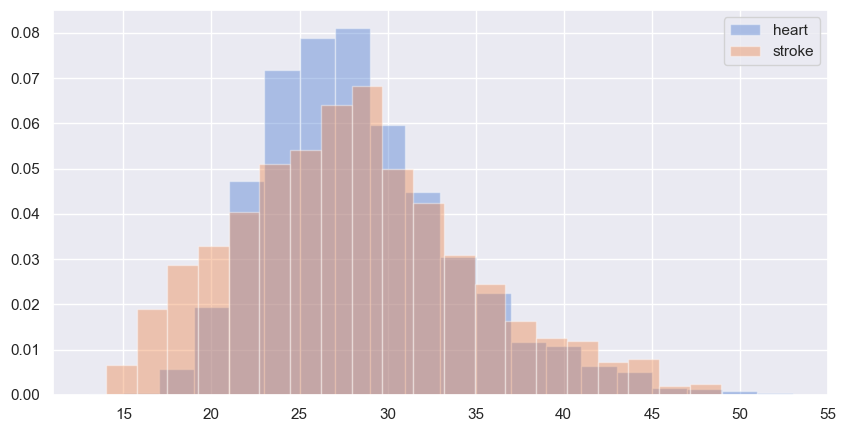

In [ ]:
x = data_heart['BMI']
y = data_stroke['bmi']

plt.figure(figsize=(10,5))
plt.hist(x, bins=20, density=True, alpha=0.4, label='heart')
plt.hist(y, bins=20, density=True, alpha=0.4, label='stroke')
plt.legend()

По графику видно, что моды распределений приблизительно равны, также если посмотреть на их средние, они тоже очень близки (около 28, исходя из описывающих таблиц в первой части). Таким образом, можно предположить, что медианы этих выборок тоже равны.

Эти предположения можно сформулировать в виде следующих гипотез:

$$
\begin{aligned}
&H_0: \hspace{2mm} Me_1 = Me_2 \\
&H_1: \hspace{2mm} Me_1 \neq Me_2
\end{aligned}
$$

Построим доверительный интервал для медиан.

In [ ]:
#функция для бутстрапирования с семинара
def get_bootstrap_sample(x, B_sample=1):
    N = x.size 
    sample = np.random.choice(x, size=(N, B_sample), replace=True)
    if B_sample == 1:
        sample = sample.T[0]
    return sample

In [ ]:
x_boot = get_bootstrap_sample(x, B_sample=10**4)
x_boot = np.median(x_boot, axis=0)

y_boot = get_bootstrap_sample(y, B_sample=10**4)
y_boot = np.median(y_boot, axis=0)

In [ ]:
boot = x_boot - y_boot
alpha = 0.05
print(f'95-% доверительный интервал: {(np.quantile(boot, alpha/2))}; {round(np.quantile(boot, 1-alpha/2),1)}')

95-% доверительный интервал: -1.0; -0.4


__Вывод:__ Ноль не попадает в полученный доверительный интервал, значит на уровне значимости 5% нулевая гипотеза отвергается.

__Источники:__ семинары и курс лекций Ф.В. Ульякина "Статистические методы анализа данных".